In [1]:
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses, layers, models, metrics, Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, metrics
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import torch
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
m = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, False)

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = 'cifar-10-batches-py/test_batch'
    else:
        name = 'cifar-10-batches-py/data_batch_' + str(i + 1)
    files.append(unpickle(name))

# conv2_block3_out

In [6]:
rotations_num = 4
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [7]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [8]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [9]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

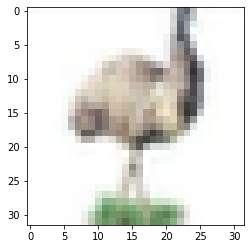

[1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


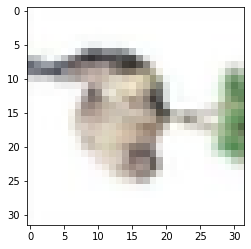

[0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


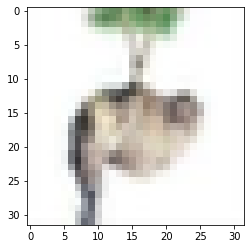

[0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


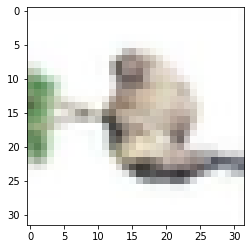

[0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [11]:
#combined_data = preprocess_input(combined_data)

In [12]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
            
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [13]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4, name='out_layer')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(rotations_num, kernel_regularizer=regularizers.l2(l = 0.0001), activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [14]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.get_layer(feature_layer_trained).output
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [15]:
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    
    return lr

In [16]:
def lr_schedule_conv(epoch, lr):
    print(lr)
    if epoch == 80:
        return lr / 5.
    if epoch == 60:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    
    return lr

In [17]:
def lr_schedule_cls(epoch, lr):
    print(lr)
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    if epoch == 10:
        return lr / 5.
    
    return lr

In [18]:
def lr_schedule_linear(epoch, lr):
    print(lr)
    if epoch < supervised_epochs // 2:
        return lr + (0.1 - 0.00001) / supervised_epochs * 2.
    else:
        return max(lr - (0.1 - 0.00001) / supervised_epochs * 2., 0.00001)
    
    return lr

In [19]:
def train_feat():
    csv_logger = CSVLogger('experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/pretext_log', append=True, separator=';')
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule), csv_logger])
    model.save('experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/pretext')
    return log

In [20]:
log_c2r4 = train_feat()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Train on 240000 samples
Epoch 1/80
240000/240000 [==============================] - 43s 179us/sample - loss: 2.1393 - accuracy: 0.5870
Epoch 2/80
240000/240000 [==============================] - 39s 164us/sample - loss: 1.5897 - accuracy: 0.6751
Epoch 3/80
240000/240000 [==============================] - 40s 166us/sample - loss: 1.4942 - accuracy: 0.7159
Epoch 4/80
240000/240000 [==============================] - 39s 165us/sample - loss: 1.4176 - accuracy: 0.7439
Epoch 5/80
240000/240000 [==============================] - 40s 165us/sample - loss: 1.3466 - accuracy: 0.7639
Epoch 6/80
240000/240000 [==============================] - 39s 164us/sample - loss: 1.2888 - accuracy: 0.7793
Epoch 7/80
240000/240000 [==============================] - 40s 165us/sample - loss: 1.2314 - accuracy: 0.7927
Epoch 8/80
240000/240000 [==============================] - 39s 164us/sample - loss: 1.1807 - accuracy: 0.8035
Epoch 9/80
240000/240000 [==============================] - 40s 167us/sample - loss: 1.1

240000/240000 [==============================] - 38s 157us/sample - loss: 0.0971 - accuracy: 0.9786
Epoch 75/80
240000/240000 [==============================] - 38s 157us/sample - loss: 0.0982 - accuracy: 0.9782
Epoch 76/80
240000/240000 [==============================] - 37s 156us/sample - loss: 0.0992 - accuracy: 0.9782
Epoch 77/80
240000/240000 [==============================] - 38s 157us/sample - loss: 0.0983 - accuracy: 0.9782
Epoch 78/80
240000/240000 [==============================] - 38s 158us/sample - loss: 0.0964 - accuracy: 0.9789
Epoch 79/80
240000/240000 [==============================] - 38s 157us/sample - loss: 0.0979 - accuracy: 0.9782
Epoch 80/80
240000/240000 [==============================] - 38s 156us/sample - loss: 0.0989 - accuracy: 0.9780
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: experiments/resnet50/rotation-4/conv2_block3_out/pretext/assets


In [22]:
def get_cls_model(name = saved_name, use_features = True, percent = 100):
    if use_features:
        model = tf.keras.models.load_model('experiments/'+str(name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/pretext')
    else:
        model = tf.keras.models.load_model('emptyResNet')
        
    if percent >= 50:
        l = model.get_layer(feature_layer).output
    else:
        l = model.get_layer(first_resnet_layer).output
        
    #model = tf.keras.models.load_model(cnn_name)
    #l = model.get_layer(feature_layer_cnn).output
    
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [25]:
def train_cls(train_features = True):
    csv_logger = CSVLogger('experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/downstream_log', append=True, separator=';')
    cls_model = get_cls_model()
    cls_model.summary()
    
    if not train_features:
        for l in cls_model.layers[:-12]:
            l.trainable = False
            
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule), csv_logger],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    cls_model.save('experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/downstream')
    return cls_log

In [ ]:
cls_train_features_c2r4 = train_cls(True)

In [ ]:
cls_no_train_features_c2r4 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'], 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 2

In [ ]:
rotations_num = 2
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c2r2 = train_feat()

In [ ]:
cls_train_features_c2r2 = train_cls(True)

In [ ]:
cls_no_train_features_c2r2 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy', 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 8

In [ ]:
rotations_num = 8
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c2r8 = train_feat()

In [ ]:
cls_train_features_c2r8 = train_cls(True)

In [ ]:
cls_no_train_features_c2r8 = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/train',
              rotation_2_fine_tuning_accuracy = cls_train_features_c2r2.history['accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c2r2.history['accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c2r4.history['accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c2r4.history['accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c2r8.history['accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c2r8.history['accuracy'])

In [ ]:
plot_training(name = 'Validation accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/validation',
              rotation_2_fine_tuning_accuracy = cls_train_features_c2r2.history['val_accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c2r2.history['val_accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c2r4.history['val_accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c2r4.history['val_accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c2r8.history['val_accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c2r8.history['val_accuracy'])

In [ ]:
#conv3_block4_out

# conv3_block4_out

In [ ]:
rotations_num = 4
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv3_block4_out'
feature_layer = 'conv3_block4_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c3r4 = train_feat()

In [ ]:
cls_train_features_c3r4 = train_cls(True)

In [ ]:
cls_no_train_features_c3r4 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'], 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 2

In [ ]:
rotations_num = 2
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

# feature_layer_trained = 'conv2_block3_out'
# feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c3r2 = train_feat()

In [ ]:
cls_train_features_c3r2 = train_cls(True)

In [ ]:
cls_no_train_features_c3r2 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy', 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 8

In [ ]:
rotations_num = 8
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

# feature_layer_trained = 'conv2_block3_out'
# feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c3r8 = train_feat()

In [ ]:
cls_train_features_c3r8 = train_cls(True)

In [ ]:
cls_no_train_features_c3r8 = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/train',
              rotation_2_fine_tuning_accuracy = cls_train_features_c3r2.history['accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c3r2.history['accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c3r4.history['accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c3r4.history['accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c3r8.history['accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c3r8.history['accuracy'])

In [ ]:
plot_training(name = 'Validation accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/validation',
              rotation_2_fine_tuning_accuracy = cls_train_features_c3r2.history['val_accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c3r2.history['val_accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c3r4.history['val_accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c3r4.history['val_accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c3r8.history['val_accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c3r8.history['val_accuracy'])

# conv4_block6_out

In [ ]:
rotations_num = 4
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv4_block6_out'
feature_layer = 'conv4_block6_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c4r4 = train_feat()

In [ ]:
cls_train_features_c4r4 = train_cls(True)

In [ ]:
cls_no_train_features_c4r4 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'], 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 2

In [ ]:
rotations_num = 2
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

# feature_layer_trained = 'conv2_block3_out'
# feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c4r2 = train_feat()

In [ ]:
cls_train_features_c4r2 = train_cls(True)

In [ ]:
cls_no_train_features_c4r2 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy', 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 8

In [ ]:
rotations_num = 8
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

# feature_layer_trained = 'conv2_block3_out'
# feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c4r8 = train_feat()

In [ ]:
cls_train_features_c4r8 = train_cls(True)

In [ ]:
cls_no_train_features_c4r8 = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/train',
              rotation_2_fine_tuning_accuracy = cls_train_features_c4r2.history['accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c4r2.history['accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c4r4.history['accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c4r4.history['accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c4r8.history['accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c4r8.history['accuracy'])

In [ ]:
plot_training(name = 'Validation accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/validation',
              rotation_2_fine_tuning_accuracy = cls_train_features_c4r2.history['val_accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c4r2.history['val_accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c4r4.history['val_accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c4r4.history['val_accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c4r8.history['val_accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c4r8.history['val_accuracy'])

# conv5_block3_out

In [ ]:
rotations_num = 4
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv5_block3_out'
feature_layer = 'conv5_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c5r4 = train_feat()

In [ ]:
cls_train_features_c5r4 = train_cls(True)

In [ ]:
cls_no_train_features_c5r4 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'], 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 2

In [ ]:
rotations_num = 2
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

# feature_layer_trained = 'conv2_block3_out'
# feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c5r2 = train_feat()

In [ ]:
cls_train_features_c5r2 = train_cls(True)

In [ ]:
cls_no_train_features_c5r2 = train_cls(False)

In [ ]:
# plot_training(name = 'Train accuracy',
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/train',
#               fine_tuning_accuracy = cls_train_features.history['accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
# plot_training(name = 'Validation accuracy', 
#               filename = 'experiments/'+str(saved_name)+'/rotation-'+str(rotations_num)+'/'+str(feature_layer_trained)+'/validation',
#               fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
#               feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 8

In [ ]:
rotations_num = 8
augment_num = 10

saved_name = 'resnet50'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

# feature_layer_trained = 'conv2_block3_out'
# feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
log_c5r8 = train_feat()

In [ ]:
cls_train_features_c5r8 = train_cls(True)

In [ ]:
cls_no_train_features_c5r8 = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/train',
              rotation_2_fine_tuning_accuracy = cls_train_features_c5r2.history['accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c5r2.history['accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c5r4.history['accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c5r4.history['accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c5r8.history['accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c5r8.history['accuracy'])

In [ ]:
plot_training(name = 'Validation accuracy', 
              filename = 'plots/'+str(saved_name)+'/'+str(feature_layer_trained)+'/validation',
              rotation_2_fine_tuning_accuracy = cls_train_features_c5r2.history['val_accuracy'],
              rotation_2_feature_extracting_accuracy = cls_no_train_features_c5r2.history['val_accuracy'],
              rotation_4_fine_tuning_accuracy = cls_train_features_c5r4.history['val_accuracy'],
              rotation_4_feature_extracting_accuracy = cls_no_train_features_c5r4.history['val_accuracy'],
              rotation_8_fine_tuning_accuracy = cls_train_features_c5r8.history['val_accuracy'],
              rotation_8_feature_extracting_accuracy = cls_no_train_features_c5r8.history['val_accuracy'])